In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
from time import time
import random
import json
import argparse

from data_loader import SeqDataLoader
from models.CNN_LSTM import CNN_LSTM
from models.Res_CNN_LSTM import Res_CNN_LSTM
from models.Res_SE_CNN_LSTM import Res_SE_CNN_LSTM
from models.SE_CNN_LSTM import SE_CNN_LSTM
from models.lstm import LSTMPredictor


In [2]:
def set_global_seed(seed=42):
    # 设置 Python 的随机种子
    random.seed(seed)
    # 设置 NumPy 的随机种子
    np.random.seed(seed)
    # 设置 PyTorch 的 CPU 随机种子
    torch.manual_seed(seed)
    # 设置 PyTorch 的 CUDA 随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # 禁用 CUDA 卷积操作的非确定性算法
        torch.backends.cudnn.deterministic = True
        # 禁用 CUDA 卷积操作的自动寻找最优算法
        torch.backends.cudnn.benchmark = False

set_global_seed()

In [36]:

# config_path = './run_swat.json'
# if not os.path.exists(config_path):
#     raise FileNotFoundError(f"Config file not found: {config_path}")
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')
# with open(config_path, 'r') as f:
#     config = json.load(f)
# model_list = [Res_SE_CNN_LSTM 0, Res_CNN_LSTM 1, CNN_LSTM 2, SE_CNN_LSTM 3, LSTMPredictor 4]

config = {
    "dataset_args": {
        "dataset": "swat",
        "train_data_path": "./dataset/swat/train.csv",
        "test_data_path": "./dataset/swat/test.csv",
        "winsize": 30,
        "step": 10
    },
    "model_args": {
        "model": 3,
        "input_dim": 51,
        
        "cnn1": 128,
        "k1": 5,
        "pad1": 2,
        "SEratio1": 16,
        "maxpool1": 2,

        "cnn2": 64,
        "k2": 5,
        "pad2": 2,
        "maxpool2": 2,
        "SEratio2": 16,

        "hidden_dim": 64,
        "lstm_layers": 1
    },
    "training_args": {
        "model_dir": None,
        "lr": 0.001,
        "epochs": 10,
        "batch_size": 32,
        "AE_MODEL": False,
        "threshold": 0.5
    }
}

dataset_args = config["dataset_args"]
model_args = config["model_args"]
training_args = config["training_args"]

AE_MODEL = training_args["AE_MODEL"]   # 是否是自编码器模型

# 检测是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [5]:

"""数据加载"""
dataset_name = dataset_args["dataset"]
train_data = SeqDataLoader(dataset_path=dataset_args["train_data_path"], win_size=dataset_args["winsize"], step=dataset_args["step"], name=f"{dataset_name} Train")
print(f'Train data length: {len(train_data)}')
print('Data sample shape:', train_data[0][0].shape)

"""数据加载"""
dataset_name = dataset_args["dataset"]
test_data = SeqDataLoader(dataset_path=dataset_args["test_data_path"], win_size=dataset_args["winsize"], step=1, name=f"{dataset_name} Test")
y_true = test_data.get_test_labels()
print(f'Test data length {len(test_data)}')
print(f'Test set Normal : {np.sum(y_true == 0)}; Attack : {np.sum(y_true == 1)}')
print('Data sample shape:', test_data[0][0].shape)
y_true_1 = np.where(y_true==1)[0]
print(len(y_true_1))

Loading swat Train data, window size is 30, step is 10
swat Train data shape: (495000, 51)
Train data length: 49497
Data sample shape: (30, 51)
Loading swat Test data, window size is 30, step is 1
swat Test data shape: (449919, 51)
Test data length 449889
Test set Normal : 395298; Attack : 54621
Data sample shape: (30, 51)
54621


In [ ]:

"""模型创建"""
data_dim = train_data[0][0].shape[-1]
model_list = [Res_SE_CNN_LSTM, Res_CNN_LSTM, CNN_LSTM, SE_CNN_LSTM, LSTMPredictor]
model = model_list[model_args["model"]](model_args)  # 选择模型
# model = SE_CNN_LSTM(model_args)  # 选择模型
print(model.ModelName)
model.to(device)  # 将模型移动到GPU上

filenameWithoutExt = f'{model.ModelName}_{dataset_args["dataset"]}_{int(time())}'

"""模型训练"""
learning_rate = training_args["lr"]
num_epochs = training_args["epochs"]
batch_size = training_args["batch_size"]
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# 训练循环，显示进度条
losses = []
model.train()
for epoch in tqdm(range(num_epochs)):
    for i, (x, x_1) in enumerate(data_loader):
        optimizer.zero_grad()
        x = x.to(device)  # 将数据移动到GPU上
        x_1 = x_1.to(device)  # 将数据移动到GPU上
        y = model(x)
        if AE_MODEL:
            loss = criterion(y[:,-1,:], x[:,-1,:])  # 自编码器的目标是重构，用窗口内的最后一步比较误差
        else:
            loss = criterion(y, x_1)  # 下一步的数据作为预测目标
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if i % 500 == 0:
            print(f'Epoch {epoch}, batch {i}, loss: {loss.item()}')
# 保存模型
torch.save(model.state_dict(), f"./checkpoints/{filenameWithoutExt}.pth")
config["training_args"]["model_dir"] = f"./checkpoints/{filenameWithoutExt}.pth"
print(f"Model saved to ./checkpoints/{filenameWithoutExt}.pth")
# 绘图
plt.plot(losses, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


"""结果保存"""
# 保存超参数结果到json文件
with open(f'./checkpoints/{filenameWithoutExt}.json', 'w') as f:
    json.dump({'args': config}, f, indent=4)
    print(f"Config saved to ./checkpoints/{filenameWithoutExt}.json")


SE_CNN_LSTM


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, batch 0, loss: 0.48735329508781433
Epoch 0, batch 500, loss: 0.03359006345272064
Epoch 0, batch 1000, loss: 0.17010755836963654
Epoch 0, batch 1500, loss: 0.09548767656087875


 10%|█         | 1/10 [00:22<03:20, 22.33s/it]

Epoch 1, batch 0, loss: 0.374169260263443
Epoch 1, batch 500, loss: 0.013540904968976974
Epoch 1, batch 1000, loss: 0.01645681820809841
Epoch 1, batch 1500, loss: 0.017360754311084747


 20%|██        | 2/10 [00:48<03:18, 24.83s/it]

Epoch 2, batch 0, loss: 0.0340377502143383
Epoch 2, batch 500, loss: 0.02877638302743435
Epoch 2, batch 1000, loss: 0.028212770819664
Epoch 2, batch 1500, loss: 0.024742070585489273


 30%|███       | 3/10 [01:08<02:37, 22.50s/it]

Epoch 3, batch 0, loss: 0.027426470071077347
Epoch 3, batch 500, loss: 0.013452707789838314
Epoch 3, batch 1000, loss: 0.07154501229524612
Epoch 3, batch 1500, loss: 0.012029027566313744


 40%|████      | 4/10 [01:27<02:07, 21.26s/it]

Epoch 4, batch 0, loss: 0.010744838044047356
Epoch 4, batch 500, loss: 0.025542479008436203
Epoch 4, batch 1000, loss: 0.01229985523968935
Epoch 4, batch 1500, loss: 0.022380400449037552


 50%|█████     | 5/10 [01:46<01:41, 20.26s/it]

Epoch 5, batch 0, loss: 0.046444475650787354
Epoch 5, batch 500, loss: 0.03403294458985329
Epoch 5, batch 1000, loss: 0.02333269640803337
Epoch 5, batch 1500, loss: 0.016491644084453583


 60%|██████    | 6/10 [02:04<01:17, 19.40s/it]

Epoch 6, batch 0, loss: 0.026759551838040352
Epoch 6, batch 500, loss: 0.0669647678732872
Epoch 6, batch 1000, loss: 0.02121538110077381
Epoch 6, batch 1500, loss: 0.03621130809187889


 70%|███████   | 7/10 [02:26<01:01, 20.50s/it]

Epoch 7, batch 0, loss: 0.03609266132116318
Epoch 7, batch 500, loss: 0.02524128556251526
Epoch 7, batch 1000, loss: 0.015512969344854355
Epoch 7, batch 1500, loss: 0.031049691140651703


 80%|████████  | 8/10 [03:18<01:00, 30.33s/it]

Epoch 8, batch 0, loss: 0.020478414371609688
Epoch 8, batch 500, loss: 0.016978073865175247
Epoch 8, batch 1000, loss: 0.011600777506828308


100%|██████████| 1547/1547 [00:03<00:00, 483.44it/s]


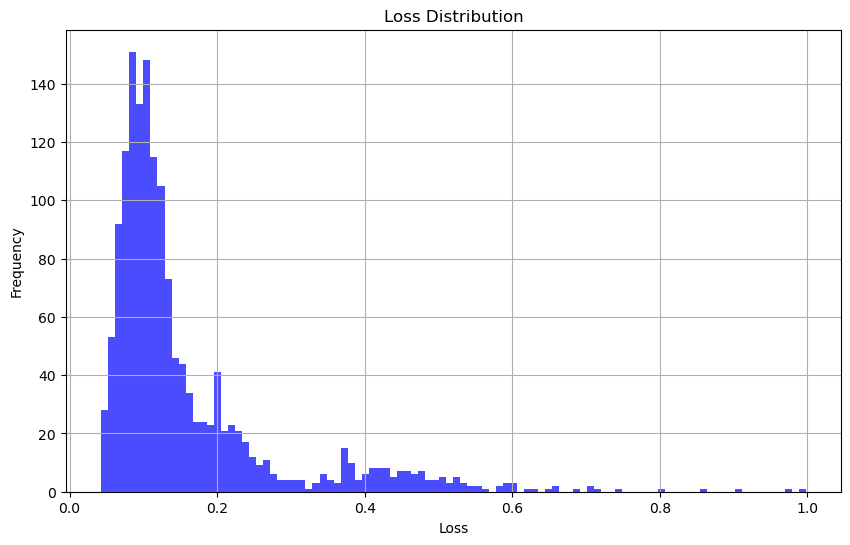

In [33]:
model.eval()
losses4train = []
with torch.no_grad():
    for x, x_1 in tqdm(data_loader):
        x = x.to(device)
        x_1 = x_1.to(device)
        y = model(x)
        if AE_MODEL:
            loss = criterion(y[:,-1,:], x[:,-1,:])     # 自编码器的目标是重构，用窗口内的最后一步比较误差
        else:
            loss = criterion(y, x_1)     # 下一步的数据作为预测目标

        losses4train.append(loss.item())

# 绘制误差数值分布，以便选择阈值
plt.figure(figsize=(10, 6))
plt.hist(losses4train, bins=100, color='blue', alpha=0.7)
plt.title('Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.grid()
plt.savefig(f"./checkpoints/{filenameWithoutExt}_loss_distribution.png")
plt.show()


100%|██████████| 7030/7030 [00:26<00:00, 267.58it/s]


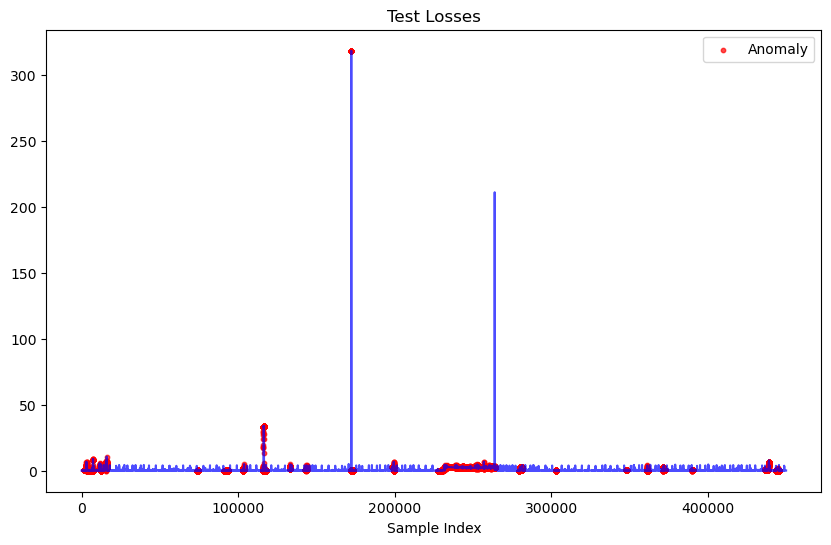

In [34]:

"""模型评估"""
test_losses = []
criterion = nn.MSELoss(reduction='none')
test_data_loader = DataLoader(test_data, batch_size=64, shuffle=False)  # 评估所用batch_size不影响
with torch.no_grad():
    for x, x_1 in tqdm(test_data_loader):
        x = x.to(device)
        x_1 = x_1.to(device)
        y = model(x)
        if AE_MODEL:
            loss = criterion(y[:,-1,:], x[:,-1,:]).mean(dim=1)     # 自编码器的目标是重构，用窗口内的最后一步比较误差
        else:
            loss = criterion(y, x_1).mean(dim=1)     # 下一步的数据作为预测目标

        test_losses += loss.tolist()

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(test_losses, color='blue', alpha=0.7)
plt.scatter(y_true_1, np.array(test_losses)[y_true_1], color='red', label='Anomaly', alpha=0.7, s=10)
plt.title('Test Losses')
plt.xlabel('Sample Index')
plt.legend()



In [35]:
config["training_args"]["threshold"] = 0.4
text = []
# thresholds = np.percentile(test_losses, [80, 85, 90, 95, 99]).tolist()
thresholds = np.arange(0.6, 1.51, 0.1).tolist()
# thresholds += [config["training_args"]["threshold"]]  

for threshold in thresholds:
    y_pred = (np.array(test_losses) > threshold).astype(int)
    if AE_MODEL:    
        y_pred = np.concatenate([np.zeros(dataset_args["winsize"]-1), y_pred]) # 自编码器的预测是窗口内的最后一步
        y_pred = np.concatenate([y_pred, np.zeros(1)])     # 由于数据集构造是面向预测的，最后一步不在训练集里面
    else:
        y_pred = np.concatenate([np.zeros(dataset_args["winsize"]), y_pred])  # 预测下一步
    text.append(f'threshold: {threshold}\n' + classification_report(y_true, y_pred, target_names=['Normal', 'Attack']) + '\n')
    print(text[-1])

"""结果保存"""
# 保存评估结果到json文件
with open(f'./checkpoints/{filenameWithoutExt}.json', 'w') as f:
    json.dump({'args': config, 'classification_report': text}, f, indent=4)

threshold: 0.6
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.97    395298
      Attack       0.79      0.72      0.75     54621

    accuracy                           0.94    449919
   macro avg       0.87      0.85      0.86    449919
weighted avg       0.94      0.94      0.94    449919


threshold: 0.7
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97    395298
      Attack       0.83      0.72      0.77     54621

    accuracy                           0.95    449919
   macro avg       0.90      0.85      0.87    449919
weighted avg       0.95      0.95      0.95    449919


threshold: 0.7999999999999999
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97    395298
      Attack       0.86      0.71      0.78     54621

    accuracy                           0.95    449919
   macro avg       0.91      0.85      0.87    449919
weighted avg